In [1]:
import pandas as pd
import numpy as np

# Загрузка данных

## Тестовые данные

Тестовые данные для kaggle были предварительно обработаны и помещены в формат pandas.DataFrame. В прошлом соревновании точность предсказаний модели на кросс валидации отличалась от итогового результата kaggle, поэтому, чтобы не работать вслепую, я их разметил (столбец "y_ideal"). Впрочем, как показала работа, похоже даже я сам не могу точно определить какой отзыв положительный, а какой - отрицательный)

In [2]:
ktest_ds = pd.read_csv('test_ds.csv', encoding='UTF-8', index_col=0)
ktest_ds.head()

,text,y_ideal
0,"Ужасно слабый аккумулятор, это основной минус ...",0
1,ценанадежность-неубиваемостьдолго держит батар...,1
2,"подробнее в комментариях\nК сожалению, факт по...",0
3,я любительница громкой музыки. Тише телефона у...,0
4,"Дата выпуска - 2011 г, емкость - 1430 mAh, тех...",1


## Парсинг сайтов

In [3]:
import requests
import bs4
import csv
import os

В тестовом датасете упоминались сотовые телефоны с qwerty клавиатурой. Поиск выдал мне страничку на torg.mail.ru. К тому же, этот сайт совсем не сопротивляется парсингу.

In [4]:
def parse_torgmailru(url, num=None):
    # Очищаем файл для логирования
    writer = csv.writer(open('torgmailru_parsed.csv','w'))
    
    ind = 0
    while True:
        ind += 1
        print 'at', ind
        
        if ind == num:
            print 'Stopping at {}'.format(ind)
            break
        
        cur_url = '{}/?page={}'.format(url, ind)
        req = requests.get(cur_url)
        if req.status_code != 200:
            raise Exception('Cant get url {} Status code {}'.format(cur_url, req.status_code))
            
        parser = bs4.BeautifulSoup(req.text, 'lxml')
        items = parser.find_all('div', attrs={'class':'review-item__body'})
        
        if items==[]:
            break
        
        for item in items:
            text = ''
            paragraphs = item.find_all('p',attrs={'class':'review-item__paragraph'})
            
            for p in paragraphs:
                if p.find('a', attrs={'class':'more'}):
                    text += p.find('a', attrs={'class':'more'}).attrs['full-text']
                else:
                    text += p.find('span',attrs={'class':'js-more-text'}).text
            text = text.encode('UTF-8')    
                
            rat = item.find('span', attrs={'class':'review-item__rating-counter'}).text.replace(',','.')
            writer.writerow([text,rat])
        del writer    

In [5]:
#parse_torgmailru('https://torg.mail.ru/review/goods/844/')

In [6]:
torgmail_ds = pd.read_csv('torgmailru_parsed.csv', header=None, names=['text','rating'])
torgmail_ds = torgmail_ds.drop_duplicates()
torgmail_ds.head()

,text,rating
0,Это был первый мой смарт. Его я выбирал тщател...,5.0
1,"Всегда был предан самсунгу, отдал за него 19 0...",3.0
2,сенсор здох через 5 лет после покупки . если п...,4.5
3,Телефон отличный! Мощная батарея! По началу за...,5.0
4,Китай есть Китай. Разъём для зарядки заменили...,2.0


In [7]:
torgmail_ds[torgmail_ds['rating']>=4.0].shape, torgmail_ds[torgmail_ds['rating']<3.0].shape

((14009, 2), (1692, 2))

Положительных отзывов намного больше, чем отрицательных. Попробуем распарсить ещё сайты.

In [8]:
def parse_nanegative():
    # Очищаем файл для логирования
    writer = csv.writer(open('nanegative_parsed.csv','w'))
    
    for page in tqdm_notebook(range(1,34+1)):
        url = 'https://nanegative.ru/search?q=телефон&page={}'.format(page)
        req = requests.get(url)
    
        if req.status_code != 200:
            raise Exception('Cant get url {} Status code {}'.format(url, req.status_code))
    
        parser = bs4.BeautifulSoup(req.text, 'lxml')
        
        list_boxes = parser.find_all('div',attrs={'class':'find-list-box'})
        for lb in list_boxes:
            url1 = 'https://nanegative.ru'+lb.a.attrs['href']
            req1 = requests.get(url1)
            if req1.status_code != 200:
                raise Exception('Cant get url {} Status code {}'.format(url1, req1.status_code))
            
            parser = bs4.BeautifulSoup(req1.text, 'lxml')
            
            rev_boxes = parser.find_all('div',attrs={'class':'reviewers-box'})
            for rb in rev_boxes:
                pro = rb.find('td',attrs={'itemprop':'pro'}).text
                contra = rb.find('td',attrs={'itemprop':'contra'}).text
                rev = rb.find('td',attrs={'itemprop':'reviewBody'}).text
                review = " ".join([pro, contra, rev])
                review = review.encode('UTF-8')    
                rating = float(rb.find('span',attrs={'itemprop':'ratingValue'}).text)
                
                
                writer.writerow([review,rating])
    del writer    

In [9]:
#parse_nanegative()

In [10]:
naneg_ds = pd.read_csv('nanegative_parsed.csv',header=None,names=['text','rating'])
naneg_ds = naneg_ds.drop_duplicates()
naneg_ds.head()

,text,rating
0,как звонилка в норме ..фото для себя норма не ...,3.0
1,"Приятная на ощупь крышка, прочный Батарея, нет...",3.0
2,Проходила с ним уже почти полтора года. Понача...,3.0
3,ни чего 1 тачскрин плохо работает через пол го...,1.0
4,"Дешевый, красивый, легкий. Телефон полностью н...",2.0


In [11]:
from sklearn.utils import shuffle

In [12]:
train_ds = torgmail_ds.append(naneg_ds)
train_ds = shuffle(train_ds)
train_ds.shape

(20358, 2)

In [13]:
train_ds[train_ds['rating']>=4.0].shape, train_ds[train_ds['rating']<3.0].shape

((14009, 2), (3117, 2))

Ситуация не сильно улучшилась, хотя отрицательных отзывов стало больше.

Так у меня не получилось совершенно точно классифицировать отзывы из предложенной тестовой выборки, создадим ещё одну тестовую выборку с известными оценками тональности на которой будем оценивать качество.

In [14]:
test_ds = train_ds[train_ds['rating']>=5.0][:50]
test_ds = test_ds.append(train_ds[train_ds['rating']<2.0][:50])
train_ds = train_ds.drop(labels=test_ds.index)
test_ds = shuffle(test_ds)
test_ds.index = range(test_ds.shape[0])
test_ds['rating'] = [1 if r>=5.0 else 0 for r in test_ds['rating']]
print test_ds.shape
test_ds.head()

(100, 2)


,text,rating
0,За 3 месяца использования нареканий нет. \t\t\...,1
1,классный телефон!с радостью пользуюсь. недорог...,0
2,"Вся техника у нас служит долго, вот и старый т...",1
3,Nokia Lumia 635 - один из самых лучших телефон...,0
4,"Стильный дизайн, удобный, хорошая вспышка, гро...",0


In [15]:
train_ds.shape, test_ds.shape

((20229, 2), (100, 2))

# Подготовка данных

In [16]:
def cleanse_ds(ds, x_key=None, no_numbers=False):
    if not x_key:
        x_key = ds.keys()[0]
    
    for idx, row in ds.iterrows():
        text = row['text']
        if type(text) is str:
            text = text.decode('UTF-8')
        text = text.lower()
        text = text.replace(u'не ', u'не')
        text = text.replace(u'\t',u' ')
        text = text.replace(u'\n',u' ')
        text = text.replace(u'<br>',u' ')
        text = text.replace(u'\r',u' ')
        if no_numbers:
            text = "".join([c for c in text if not c.isnumeric()])
        ds.at[idx, 'text'] = text
    return ds

In [17]:
def mapping(rating, up=4.0, bottom = 3.0):
    if rating >= up: return 1
    if rating <  bottom: return 0
    return np.nan

def map_ds(ds, y_key=None, up=4.0, bottom = 3.0):
    if not y_key:
        y_key = ds.keys()[1]
        
    ds[y_key] = map(lambda x: mapping(x, up=up, bottom=bottom),ds[y_key])
    ds = ds.dropna()
    ds[y_key] = map(int, ds[y_key])
    ds.index = range(ds.shape[0])
    return ds

Неочевидно, где находится порог между положительными отзывами и отрицательными. Создадим два датасета: в одном учитываются только отзывы с оценками 1 и 5, во втором - с оценками меньше 3 и больше 4.

In [18]:
cleansed_ds25 = cleanse_ds(train_ds.copy())
cleansed_ds25 = map_ds(cleansed_ds25, up=5.0, bottom=2.0)
cleansed_ds25 = cleansed_ds25.drop_duplicates()
print cleansed_ds25.shape

(9344, 2)


/home/egor/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [19]:
cleansed_ds34 = cleanse_ds(train_ds.copy())
cleansed_ds34 = map_ds(cleansed_ds34, up=4.0, bottom=3.0)
cleansed_ds34 = cleansed_ds34.drop_duplicates()
print cleansed_ds34.shape

(16812, 2)


/home/egor/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


Тестовые выборки тоже необходимо преобразовать.

In [20]:
cleansed_test = cleanse_ds(test_ds.copy())
cleansed_test.head()

,text,rating
0,за 3 месяца использования нареканий нет. ...,1
1,классный телефон!с радостью пользуюсь. недорог...,0
2,"вся техника у нас служит долго, вот и старый т...",1
3,nokia lumia 635 - один из самых лучших телефон...,0
4,"стильный дизайн, удобный, хорошая вспышка, гро...",0


In [21]:
cleansed_ktest = cleanse_ds(ktest_ds.copy())
cleansed_ktest.head()

,text,y_ideal
0,"ужасно слабый аккумулятор, это основной минус ...",0
1,ценанадежность-неубиваемостьдолго держит батар...,1
2,"подробнее в комментариях к сожалению, факт пол...",0
3,я любительница громкой музыки. тише телефона у...,0
4,"дата выпуска - 2011 г, емкость - 1430 mah, тех...",1


Так как выборки несбалансированы, уменьшим количество положительных отзывов. 

In [22]:
def downgrade_ds(ds):
    y_key = ds.keys()[1]
    downgraded = ds[ds[y_key]==1][:ds.shape[0]-sum(ds[y_key])] # Selecting 1's
    downgraded = downgraded.append(ds[ds[y_key]==0]) # Selecting 0's
    downgraded = shuffle(downgraded)
    return downgraded

In [23]:
downgraded_ds25 = downgrade_ds(cleansed_ds25)
print cleansed_ds25.shape, downgraded_ds25.shape

(9344, 2) (3144, 2)


In [24]:
downgraded_ds34 = downgrade_ds(cleansed_ds34)
print cleansed_ds34.shape, downgraded_ds34.shape

(16812, 2) (5744, 2)


# Построение модели

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from nltk.corpus import stopwords

/home/egor/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Напишем функции для удобной проверки пайплайнов и для записи результатов в файл.

In [26]:
def check_pipe(pipe, ds, cv=3):
    X,y = ds['text'], ds['rating']
    cvs = cross_val_score(pipe, X, y, cv=cv)
    print 'cross val:', cvs, cvs.mean()
    pipe.fit(X,y)
    print 'acc test :',accuracy_score(cleansed_test['rating'], pipe.predict(cleansed_test['text']))
    print 'acc ktest:',accuracy_score(cleansed_ktest['y_ideal'], pipe.predict(cleansed_ktest['text']))

In [27]:
def predict_test(pipe, ds, cv=3, fname='result1.csv'):
    X,y = ds['text'], ds['rating']
    cvs = cross_val_score(pipe, X, y, cv=cv)
    print 'cross val:', cvs, cvs.mean()
    pipe.fit(X,y)
    cleansed_ktest['y1'] = pipe.predict(cleansed_ktest['text'])
    print 'acc test :',accuracy_score(cleansed_test['rating'], pipe.predict(cleansed_test['text']))
    print 'acc ktest:',accuracy_score(cleansed_ktest['y_ideal'], cleansed_ktest['y1'])
    cleansed_ktest['y'] = ['pos' if x==1 else 'neg' for x in cleansed_ktest['y1']]
    cleansed_ktest['y'].to_csv(fname,header=True,index_label='Id')

В прошлом соревновании лучше всего себя показали пайплайны с классификатором LinearSVC и TfIdf векторизатором с символьными n-граммами. При этом, n-граммы включали в себя комбинации из как можно большего количества символов.

Каждый пайплайн проверим на обоих датасетах.

In [28]:
pipe = make_pipeline(TfidfVectorizer(ngram_range=(1,4), analyzer='char'), LinearSVC())
print 'downgraded_ds25'
check_pipe(pipe, downgraded_ds25)
print 'downgraded_ds34'
check_pipe(pipe, downgraded_ds34)

downgraded_ds25
cross val: [ 0.72232824  0.72900763  0.73664122] 0.729325699746
acc test : 0.85
acc ktest: 0.92
downgraded_ds34
cross val: [ 0.71816284  0.71421108  0.69592476] 0.709432893473
acc test : 0.85
acc ktest: 0.9


In [29]:
pipe = make_pipeline(TfidfVectorizer(ngram_range=(1,5), analyzer='char'), LinearSVC())
print 'downgraded_ds25'
check_pipe(pipe, downgraded_ds25)
print 'downgraded_ds34'
check_pipe(pipe, downgraded_ds34)

downgraded_ds25
cross val: [ 0.72328244  0.73187023  0.73759542] 0.730916030534
acc test : 0.87
acc ktest: 0.92
downgraded_ds34
cross val: [ 0.72181628  0.71421108  0.6922675 ] 0.709431620939
acc test : 0.87
acc ktest: 0.9


In [30]:
pipe = make_pipeline(TfidfVectorizer(ngram_range=(1,6), analyzer='char'), LinearSVC())
print 'downgraded_ds25'
check_pipe(pipe, downgraded_ds25)
print 'downgraded_ds34'
check_pipe(pipe, downgraded_ds34)

downgraded_ds25
cross val: [ 0.72900763  0.73568702  0.74045802] 0.735050890585
acc test : 0.86
acc ktest: 0.92
downgraded_ds34
cross val: [ 0.72077244  0.71421108  0.6922675 ] 0.709083673827
acc test : 0.88
acc ktest: 0.91


In [31]:
pipe = make_pipeline(TfidfVectorizer(ngram_range=(1,7), analyzer='char'), LinearSVC())
print 'downgraded_ds25'
check_pipe(pipe, downgraded_ds25)
print 'downgraded_ds34'
check_pipe(pipe, downgraded_ds34)

downgraded_ds25
cross val: [ 0.72232824  0.73187023  0.74236641] 0.732188295165
acc test : 0.87
acc ktest: 0.92
downgraded_ds34
cross val: [ 0.71764092  0.71421108  0.69331243] 0.708388143184
acc test : 0.88
acc ktest: 0.92


In [32]:
pipe = make_pipeline(TfidfVectorizer(ngram_range=(1,8), analyzer='char'), LinearSVC())
print 'downgraded_ds25'
check_pipe(pipe, downgraded_ds25)
print 'downgraded_ds34'
check_pipe(pipe, downgraded_ds34)

downgraded_ds25
cross val: [ 0.71183206  0.72232824  0.7471374 ] 0.727099236641
acc test : 0.87
acc ktest: 0.91
downgraded_ds34
cross val: [ 0.71659708  0.71682341  0.69487983] 0.709433438845
acc test : 0.89
acc ktest: 0.94


Почему результаты кросс валидации и тестировочных выборок различаются на 10%? Возможно, это из-за объёма выборок. Чем больше количество классифицируемых текстов, тем больше вероятность ошибиться. Хотя, казалось бы, что система везде должна давать примерно одинаковый результат.

In [33]:
downgraded_ds25.shape, downgraded_ds34.shape, test_ds.shape, ktest_ds.shape

((3144, 2), (5744, 2), (100, 2), (100, 2))

Возьмём лучшие пайплайны и отправим их на проверку.

In [34]:
pipe = make_pipeline(TfidfVectorizer(ngram_range=(1,7),analyzer='char'),LinearSVC())
predict_test(pipe, downgraded_ds34, fname='result2.csv')

cross val: [ 0.71764092  0.71421108  0.69331243] 0.708388143184
acc test : 0.88
acc ktest: 0.92


In [35]:
pipe = make_pipeline(TfidfVectorizer(ngram_range=(1,8),analyzer='char'),LinearSVC())
predict_test(pipe, downgraded_ds25, fname='result3.csv')

cross val: [ 0.71183206  0.72232824  0.7471374 ] 0.727099236641
acc test : 0.87
acc ktest: 0.91


In [36]:
pipe = make_pipeline(TfidfVectorizer(ngram_range=(1,8),analyzer='char'),LinearSVC())
predict_test(pipe, downgraded_ds34, fname='result4.csv')

cross val: [ 0.71659708  0.71682341  0.69487983] 0.709433438845
acc test : 0.89
acc ktest: 0.94


In [37]:
pipe = make_pipeline(TfidfVectorizer(ngram_range=(1,9),analyzer='char'),LinearSVC())
predict_test(pipe, downgraded_ds34, fname='result5.csv')

cross val: [ 0.72077244  0.71421108  0.69487983] 0.70995445056
acc test : 0.87
acc ktest: 0.94



# Результат kaggle

Результат получен при отправке файла results2.csv

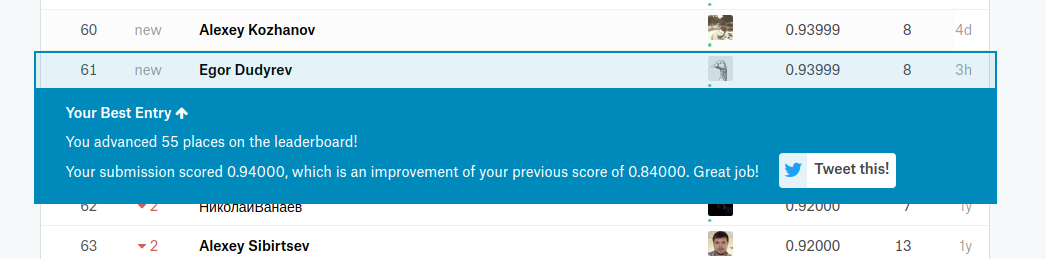